In [1]:
import numpy as np

from matplotlib import pyplot as plt

In [2]:
from pktools import*

In [36]:
num_mocks = 1000
zbin = 3

testing = True # turn on if comparing to pre-computed covariances

In [39]:
# First massage the Pk data into a form we want
for gc in ['NGC', 'SGC']:
    basedir = '/global/cscratch1/sd/sfschen/boss_data_renorm/pk/'
    fn = 'ps1D_BOSS_DR12_%s_z%d_COMPnbar_TSC_700_700_700_400_renorm.dat'%(gc,zbin)

    pkdat = read_power(basedir+fn)
    sn_val = float(pkdat['header'][27].split()[-1]) # this is with randoms
    pkdat = np.array([ pkdat['k_center'], pkdat['pk0'] + sn_val, pkdat['pk2']]).T

    np.savetxt(basedir + 'pkwsn_%s_z%d.dat'%(gc,zbin), pkdat, header='SN added equal to %.2f.'%(sn_val))

In [5]:
pkdat.shape

(40, 3)

In [16]:
pkdat = read_power(basedir+fn)

In [31]:
float(pkdat['header'][27].split()[-1])

6760.58567

In [6]:
# Load NGC Pk Mocks:
gc = 'NGC'
pks_ngc = []

basedir = '/global/cscratch1/sd/sfschen/boss_data_renorm/mock_pks/pk_%s_z%d/'%(gc,zbin)
print(basedir)

for ii in range(num_mocks):
    fn = 'ps1D_patchy_%s_z%d_COMPnbar_TSC_V6C_%d_0.5_0.75_700_700_700_400_renorm.dat' %(gc,zbin,ii+1)
    pkstruct = read_power(basedir+fn)
    
    pks_ngc += [ np.concatenate((pkstruct['pk0'], pkstruct['pk2'])),  ]
    
pks_ngc = np.array(pks_ngc)

/global/cscratch1/sd/sfschen/boss_data_renorm/mock_pks/pk_NGC_z3/


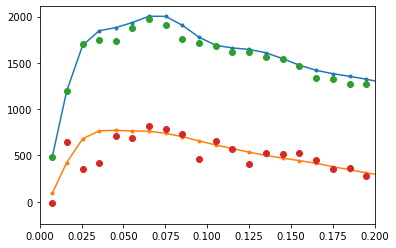

In [7]:
kdat = pkdat[:,0]
p0dat = pkdat[:,1]
p2dat = pkdat[:,2]

pks_ngc_mean = np.mean(pks_ngc,axis=0)

plt.plot(kdat, kdat * pks_ngc_mean[:40],'.-')
plt.plot(kdat, kdat * pks_ngc_mean[40:80],'.-')

plt.plot(kdat, kdat * p0dat,'o')
plt.plot(kdat, kdat * p2dat,'o')

plt.xlim(0,0.2)

np.savetxt('/global/cscratch1/sd/sfschen/boss_data_renorm/pk/mock_pk_NGC_z3.dat',\
           np.array([ kdat, pks_ngc_mean[:40], pks_ngc_mean[40:80]]).T)



In [9]:
# Load SGC Pk Mocks:
gc = 'SGC'
pks_sgc = []

basedir = '/global/cscratch1/sd/sfschen/boss_data_renorm/mock_pks/pk_%s_z%d/'%(gc,zbin)
print(basedir)

for ii in range(num_mocks):
    fn = 'ps1D_patchy_%s_z%d_COMPnbar_TSC_V6C_%d_0.5_0.75_700_700_700_400_renorm.dat' %(gc,zbin,ii+1)
    pkstruct = read_power(basedir+fn)
    
    pks_sgc += [ np.concatenate((pkstruct['pk0'], pkstruct['pk2'])),  ]
    
pks_sgc = np.array(pks_sgc)

/global/cscratch1/sd/sfschen/boss_data_renorm/mock_pks/pk_SGC_z3/


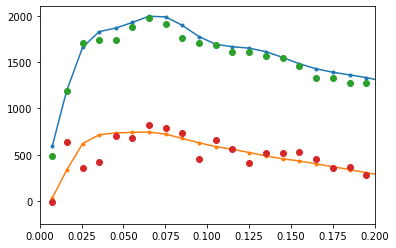

In [10]:
kdat = pkdat[:,0]
p0dat = pkdat[:,1]
p2dat = pkdat[:,2]

pks_sgc_mean = np.mean(pks_sgc,axis=0)

plt.plot(kdat, kdat * pks_sgc_mean[:40],'.-')
plt.plot(kdat, kdat * pks_sgc_mean[40:80],'.-')

plt.plot(kdat, kdat * p0dat,'o')
plt.plot(kdat, kdat * p2dat,'o')

plt.xlim(0,0.2)

np.savetxt('/global/cscratch1/sd/sfschen/boss_data_renorm/pk/mock_pk_SGC_z3.dat',\
           np.array([ kdat, pks_sgc_mean[:40], pks_sgc_mean[40:80]]).T)


In [12]:
#  Make individual covariance matrices
cov_ngc = np.cov(pks_ngc.T)
cov_sgc = np.cov(pks_sgc.T)
print(cov_ngc.shape)
print(cov_sgc.shape)
np.savetxt('covariances/cov_NGC_z%d_n%d.dat'%(zbin,num_mocks), cov_ngc)
np.savetxt('covariances/cov_SGC_z%d_n%d.dat'%(zbin,num_mocks), cov_sgc)

(80, 80)
(80, 80)


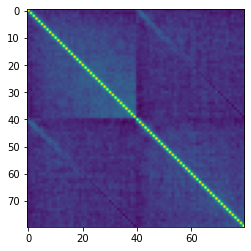

In [15]:
sigmas = np.sqrt(np.diag(cov_ngc))
corr_ngc = cov_ngc / sigmas[:,None] / sigmas[None,:]

plt.imshow(corr_ngc)

In [18]:
# Now combine:
dats = np.hstack((pks_ngc,pks_sgc,xis))
cov_joint = np.cov(dats.T)
print(cov_joint.shape)
np.savetxt('covariances/cov_joint_NGCSGCXi_z%d_n%d.dat'%(zbin,num_mocks), cov_joint)

(232, 232)


In [19]:
# Some sanity checks: how correlated are we if we choose the right cuts?
krange = (pkstruct['k_center'] > 0.02) * (pkstruct['k_center'] < 0.2)
rrange = (xidats[:,0] > 80) * (xidats[:,1] < 130)
iis = np.concatenate( (krange, krange, krange, krange, rrange, rrange) )

cov_fit = cov_joint[np.ix_(iis,iis)]

In [20]:
sigmas = np.sqrt(np.diag(cov_fit))
corr_fit = cov_fit / sigmas[:,None] / sigmas[None,:]

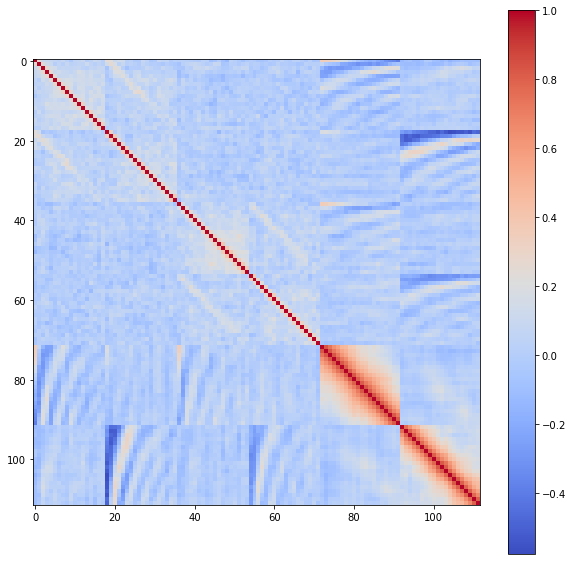

In [21]:
plt.figure(figsize=(10,10))

#plt.imshow(corr_fit, vmin=-1, vmax=1, cmap='bwr')
plt.imshow(corr_fit, cmap='coolwarm')
plt.colorbar()

In [16]:
# Sanity Check:
# The power spectra have been rescaled by:
#SGC z1: 0.8896282109744246
#SGC z3: 0.9016159434083929
#NGC z1: 0.9031526950112163
#NGC z3: 0.9103676930483875

cov_old = np.loadtxt('../boss_fixedb_bias/covariances/cov_joint_NGCSGCXi_z3.dat')

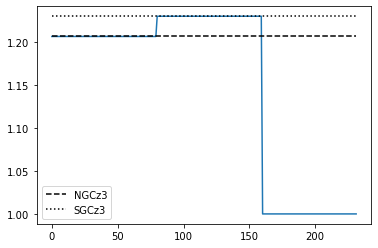

In [18]:
ii = np.arange( len(np.diag(cov_joint)) )
plt.plot(np.diag(cov_joint)/np.diag(cov_old))

plt.plot(ii, np.ones_like(ii) / 0.9103676930483875**2 ,'k--', label='NGCz3')
plt.plot(ii, np.ones_like(ii) / 0.9016159434083929**2 ,'k:', label='SGCz3')


plt.legend()